In [1]:
#NB need to use environment with python3.9 or above for ccf_streamlines to run
import nrrd
import numpy as np
import matplotlib.pyplot as plt
import ccf_streamlines.projection as ccfproj
import pathlib
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import LogNorm
import copy
import cv2
import seaborn as sb
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


In [2]:
from matplotlib import rcParams

In [3]:
reg_dir = pathlib.Path('/nemo/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/allenccf/allen_ccf_coord')
ROI_path = pathlib.Path('/nemo/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/rois')
ROI_table = pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/allenccf/ROI_vol.pkl')
allen_converted_path = pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/allenccf/allen_ccf_coord')
convert_to_flat_path = allen_converted_path.parents[1]
lcm_reg_dir = pathlib.PurePath('/nemo/lab/znamenskiyp/home/shared/code/MAPseq_processing/AC_MAPseq/Brain1_FIAA32.6a/LCM_registration')
reads_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/Sequencing/Source_target_together")
RTtosample = pd.read_csv(allen_converted_path.parents[2]/ 'Sequencing/Processed_data/UpdatedApril/tube_to_RT.csv')

areas = pd.read_csv(lcm_reg_dir/'3d_areas.csv')

In [4]:
normalised_barcode_path= pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/Sequencing/Source_target_together/barcode_matrix_normalised_no_source_cut.pkl')

In [5]:
filtered_barcodes_spike_normalised = pd.read_pickle(normalised_barcode_path)

In [6]:
#re-organise sample names in barcode table so that they match tube names for registraton
new_columns= {}
for i, r in RTtosample.iterrows():
    new_columns[r['RT primer']]= r['Tube'] #create a dictionary to rename columns in the barcode matrix with tube names rather than RT sample names
filtered_barcodes_spike_normalised = filtered_barcodes_spike_normalised.rename(columns=new_columns)

In [7]:
filtered_barcodes_spike_normalised =filtered_barcodes_spike_normalised[filtered_barcodes_spike_normalised.astype(bool).sum(axis=1)>1]

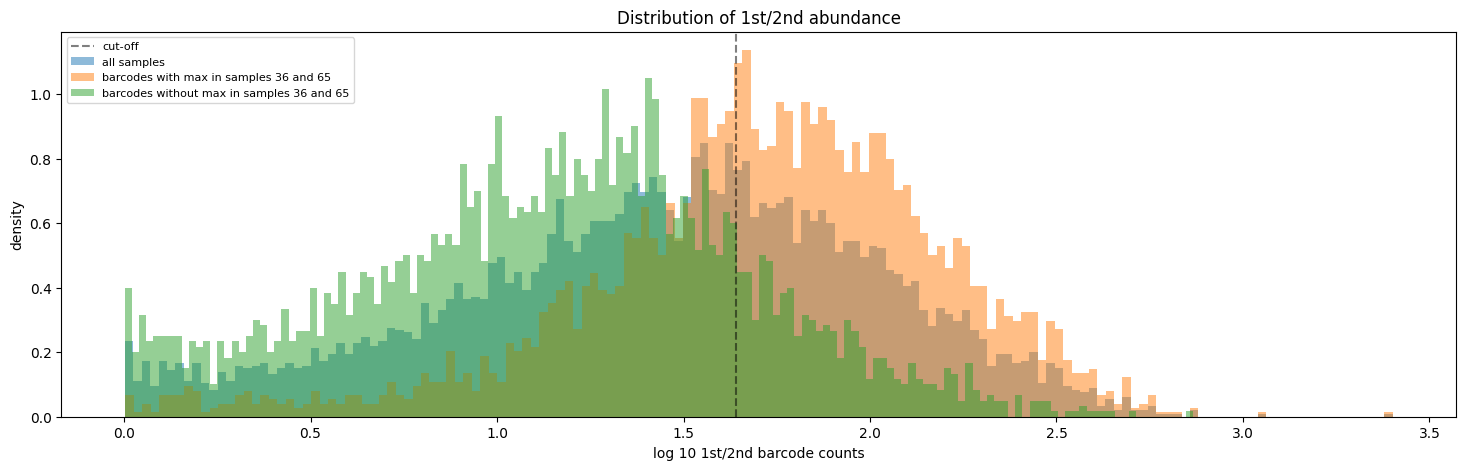

In [15]:
#plot histogram distribution of 1st/2nd abundant ratios
known_source = [36, 65]
known_source_filtered_barcodes_spike_normalised = filtered_barcodes_spike_normalised[filtered_barcodes_spike_normalised.idxmax(axis=1).isin(known_source)]
without_known_source_filtered_barcodes_spike_normalised = filtered_barcodes_spike_normalised[~filtered_barcodes_spike_normalised.idxmax(axis=1).isin(known_source)]
find_source_not_known = pd.DataFrame()
find_source_not_known['highest'] = filtered_barcodes_spike_normalised.max(axis=1) +1
find_source_not_known['second'] = filtered_barcodes_spike_normalised.apply(lambda row: row.nlargest(2).values[-1],axis=1) +1
find_source_not_known['relative_to_max'] = np.log10(find_source_not_known['highest']/find_source_not_known['second'])
plt.hist(find_source_not_known['relative_to_max'], bins=150, alpha=0.5,  density=True, label='all samples')
find_source = pd.DataFrame()
find_source['highest'] = known_source_filtered_barcodes_spike_normalised.max(axis=1) +1
find_source['second'] = known_source_filtered_barcodes_spike_normalised.apply(lambda row: row.nlargest(2).values[-1],axis=1) +1
find_source['relative_to_max'] = np.log10(find_source['highest']/find_source['second'])
plt.hist(find_source['relative_to_max'], bins=150, alpha = 0.5, density=True, label ='barcodes with max in samples 36 and 65')
no_source = pd.DataFrame()
no_source['highest'] = without_known_source_filtered_barcodes_spike_normalised.max(axis=1) +1
no_source['second'] = without_known_source_filtered_barcodes_spike_normalised.apply(lambda row: row.nlargest(2).values[-1],axis=1) +1
no_source['relative_to_max'] = np.log10(no_source['highest']/no_source['second'])
plt.hist(no_source['relative_to_max'], bins=150, alpha = 0.5, density=True, label ='barcodes without max in samples 36 and 65')
plt.title('Distribution of 1st/2nd abundance')
plt.xlabel('log 10 1st/2nd barcode counts')
plt.axvline(x =1.64, linestyle='dashed', color = "Black", label = "cut-off", alpha=0.5)
plt.ylabel('density')
plt.legend(loc='upper left', fontsize=8)



In [15]:
len(find_source_not_known[find_source_not_known['sample']==36])/len(find_source_not_known) 

0.3368766609348132

In [11]:
#since 
find_source_not_known['sample'] = filtered_barcodes_spike_normalised.idxmax(axis=1)

Text(0.5, 1.0, 'Max count for max barcode across samples')

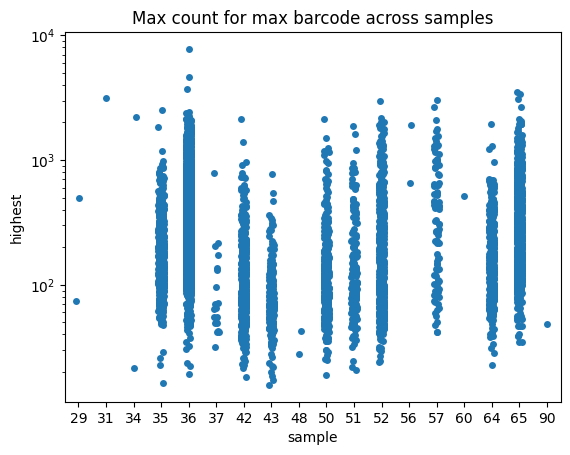

In [198]:
sb.stripplot(data=find_source_not_known, x='sample', y='highest')
plt.yscale('log')
plt.title('Max count for max barcode across samples')

Text(0.5, 1.0, '1st/2nd most abundant sample count ratio across samples with containing max barcode')

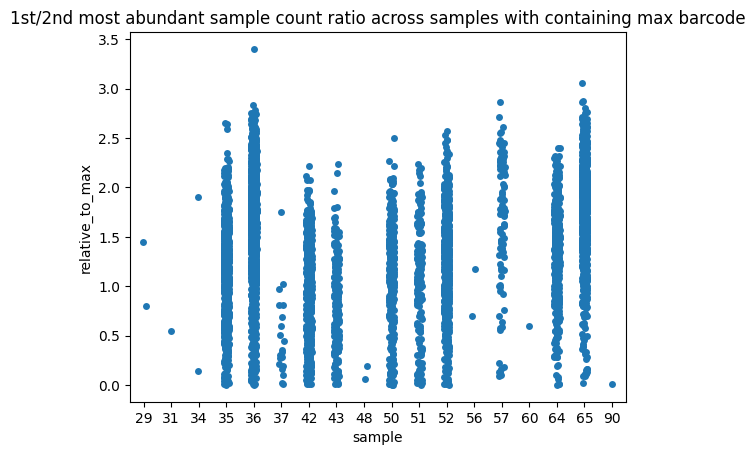

In [200]:
sb.stripplot(data=find_source_not_known, x='sample', y='relative_to_max')
plt.title('1st/2nd most abundant sample count ratio across samples with containing max barcode')


Text(0.5, 1.0, '1st/2nd most abundant sample count ratio across samples with containing max barcode')

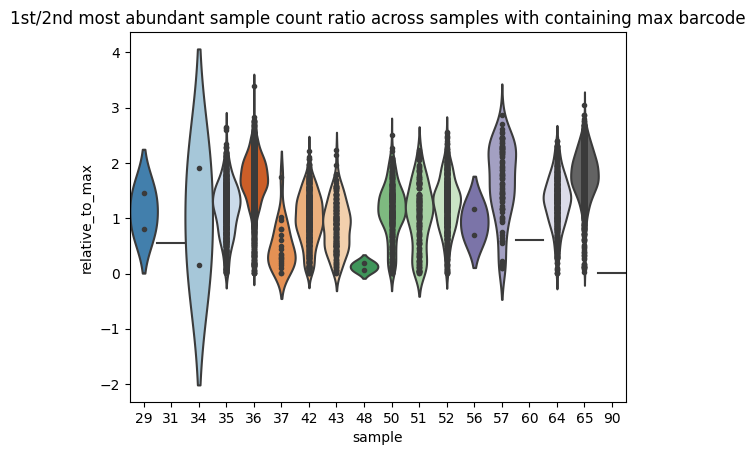

In [202]:
sb.violinplot(data=find_source_not_known, x='sample', y='relative_to_max', inner='point', scale="width", palette="tab20c", width=1)
plt.title('1st/2nd most abundant sample count ratio across samples with containing max barcode')

Text(0.5, 1.0, '1st/2nd most abundant sample count ratio across samples with containing max barcode')

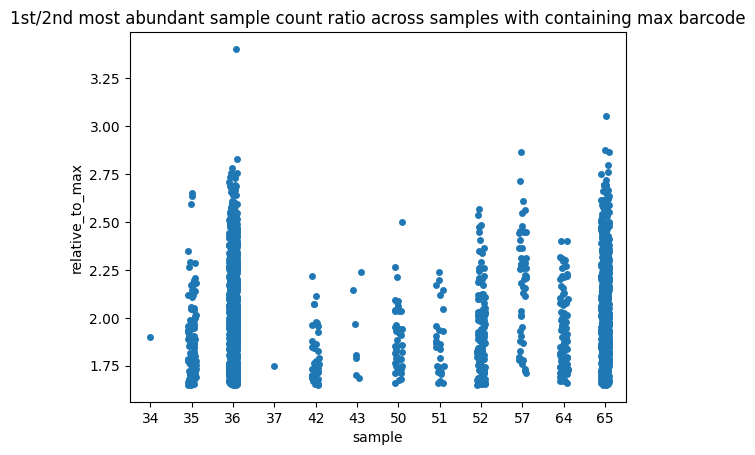

In [214]:
sb.stripplot(data=thresholded_bc, x='sample', y='relative_to_max')
plt.title('1st/2nd most abundant sample count ratio across samples with containing max barcode')


In [8]:
filtered_barcodes_spike_normalised_3samples =filtered_barcodes_spike_normalised[filtered_barcodes_spike_normalised.astype(bool).sum(axis=1)>2]
find_source_not_known_3 = pd.DataFrame()
find_source_not_known_3['highest'] = filtered_barcodes_spike_normalised_3samples.max(axis=1)
find_source_not_known_3['second_max'] = filtered_barcodes_spike_normalised_3samples.apply(lambda row: row.nlargest(3).values[-2],axis=1)
find_source_not_known_3['third_max'] = filtered_barcodes_spike_normalised_3samples.apply(lambda row: row.nlargest(3).values[-1],axis=1)
find_source_not_known_3['relative_to_max'] = np.log10(find_source_not_known_3['second_max']/find_source_not_known_3['third_max'])

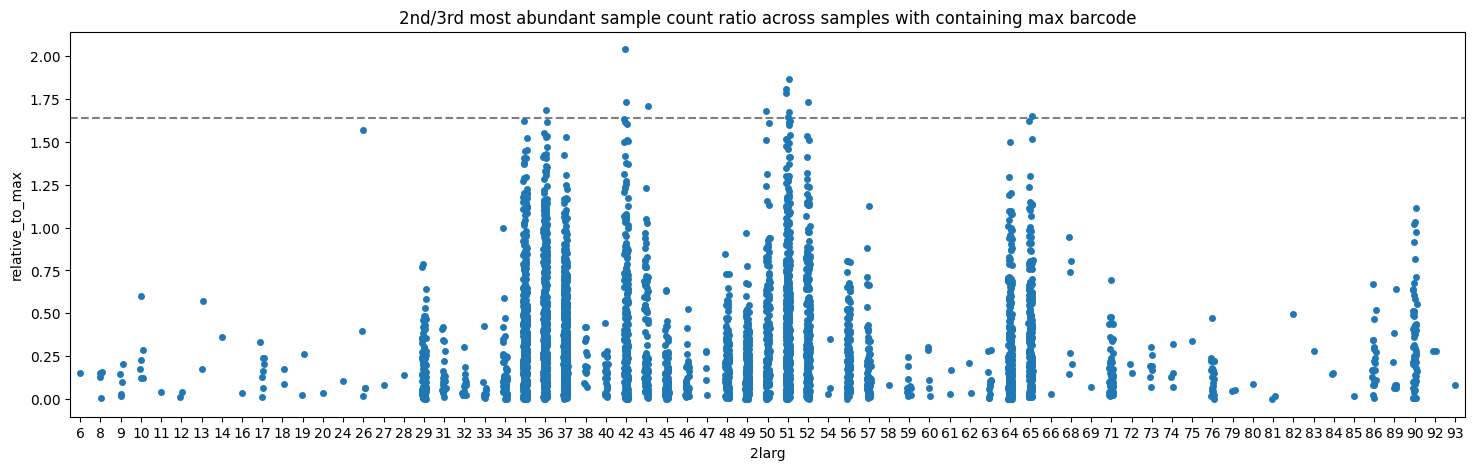

In [9]:
find_source_not_known_3['sample'] = filtered_barcodes_spike_normalised_3samples.idxmax(axis=1)
find_source_not_known_3['2larg'] = filtered_barcodes_spike_normalised_3samples.mask(filtered_barcodes_spike_normalised_3samples.eq(filtered_barcodes_spike_normalised_3samples.max(axis=1), axis=0)).idxmax(axis=1)
rcParams['figure.figsize'] = 18, 5
sb.stripplot(data=find_source_not_known_3, x='2larg', y='relative_to_max')
plt.title('2nd/3rd most abundant sample count ratio across samples with containing max barcode')
plt.axhline(y =1.64, linestyle='dashed', color = "Black", label = "cut-off", alpha=0.5)

In [10]:
threshold =find_source_not_known_3['relative_to_max'].std()*4 + find_source_not_known_3['relative_to_max'].mean()

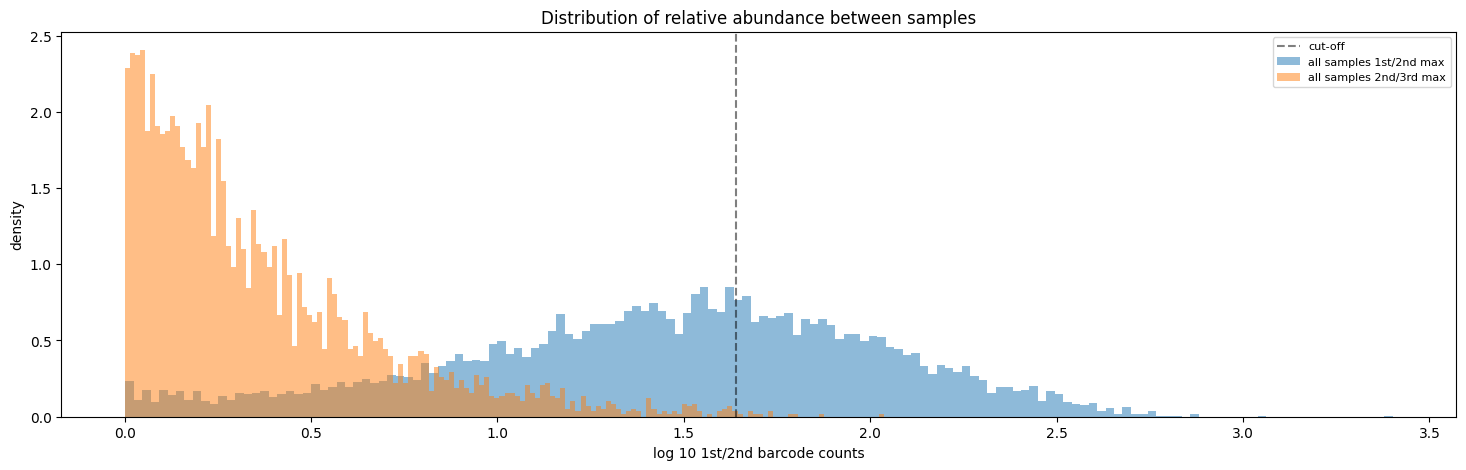

In [24]:
plt.hist(find_source_not_known['relative_to_max'], bins=150, alpha=0.5,  density=True, label='all samples 1st/2nd max')

plt.hist(find_source_not_known_3['relative_to_max'], bins=150, alpha = 0.5, density=True, label ='all samples 2nd/3rd max')
plt.title('Distribution of relative abundance between samples')
plt.xlabel('log 10 1st/2nd barcode counts')
plt.axvline(x =1.64, linestyle='dashed', color = "Black", label = "cut-off", alpha=0.5)
plt.ylabel('density')
plt.legend(loc='upper right', fontsize=8)


In [215]:
density_barcodes = pd.DataFrame()
for col in filtered_barcodes_spike_normalised.columns:
    density_barcodes[col] = filtered_barcodes_spike_normalised[col]/(areas.loc[col].sum())
thresholded_bc['max_density'] = ''
for indexes in thresholded_bc.index:
    thresholded_bc.loc[indexes, 'max_density'] = density_barcodes.loc[indexes, thresholded_bc.loc[indexes, 'sample']]


/tmp/ipykernel_77662/2518627809.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thresholded_bc['max_density'] = ''


In [216]:
thresholded_bc['vol'] = ''
for indexes in thresholded_bc.index:
    thresholded_bc.loc[indexes, 'vol'] = areas.loc[thresholded_bc.loc[indexes, 'sample']].sum()



/tmp/ipykernel_77662/4153962999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thresholded_bc['vol'] = ''


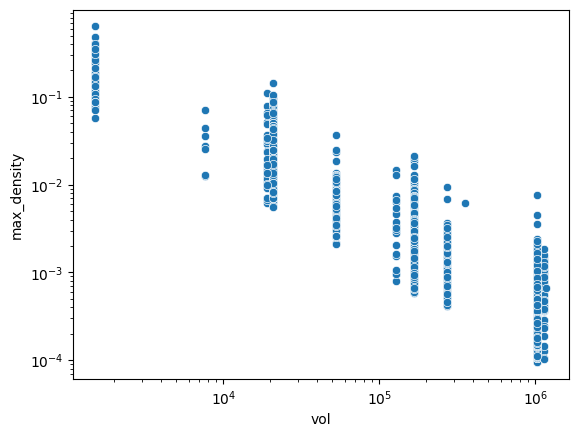

In [217]:
sb.scatterplot(x=thresholded_bc['vol'], y = thresholded_bc['max_density'])
plt.xscale('log')
plt.yscale('log')

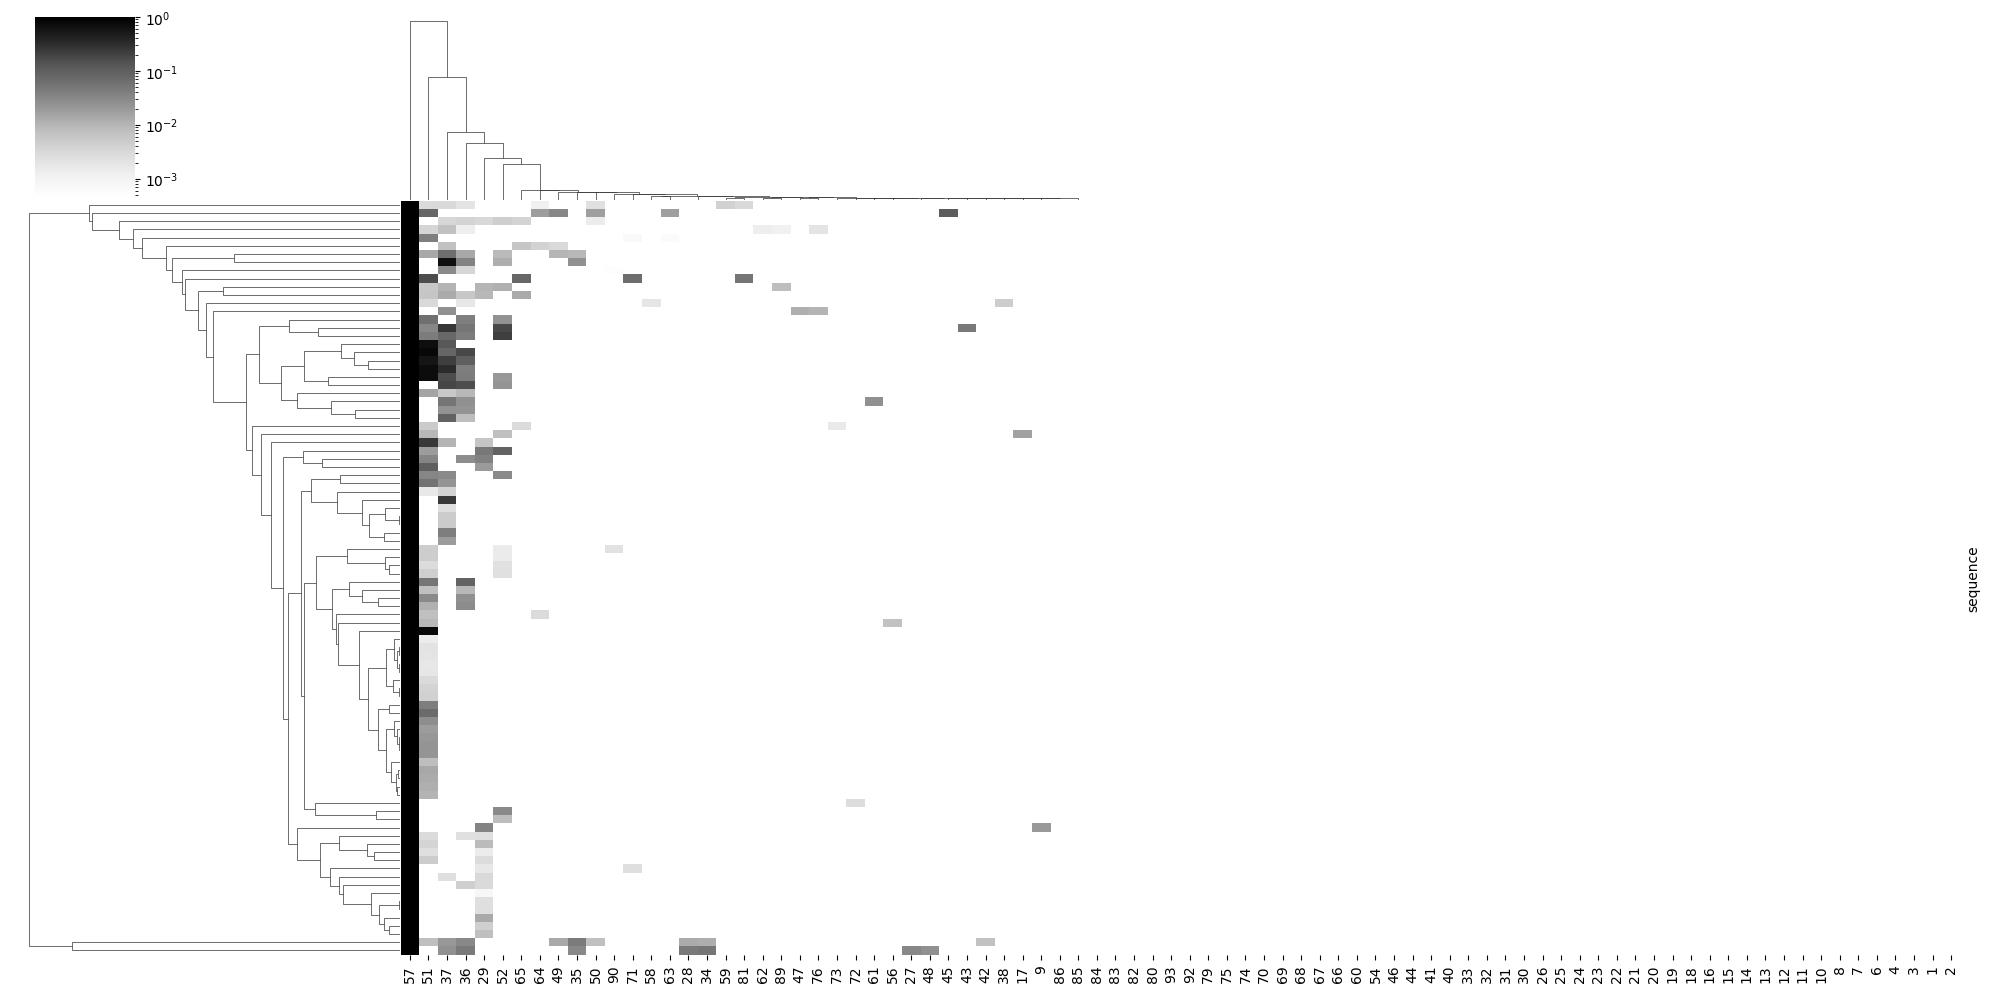

In [10]:
sb.clustermap(filtered_barcodes_spike_normalised[filtered_barcodes_spike_normalised.idxmax(axis=1)==57],metric='canberra', standard_scale=0, norm=LogNorm(), cmap="Greys", figsize=(20, 10), yticklabels=False, xticklabels=1)

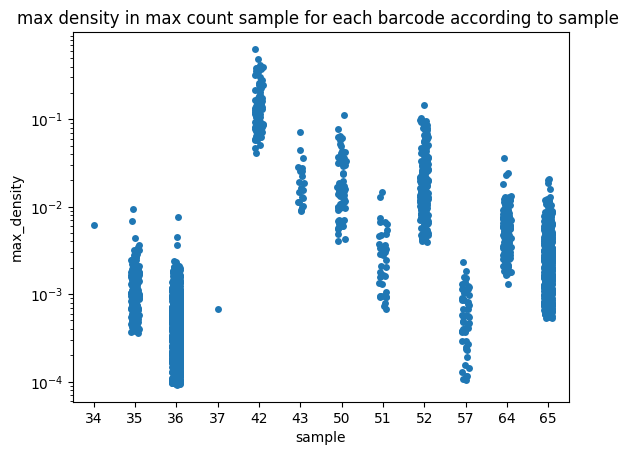

In [111]:
sb.stripplot(data=thresholded_bc, x='sample', y='max_density')
plt.title('max density in max count sample for each barcode according to sample ')
plt.yscale('log')


In [12]:
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=convert_to_flat_path/"flatmap_butterfly.nrrd",
    labels_file=convert_to_flat_path/"labelDescription_ITKSNAPColor.txt",
)

# We get the left hemisphere region boundaries with the default arguments
bf_left_boundaries = bf_boundary_finder.region_boundaries()

# And we can get the right hemisphere boundaries that match up with
# our projection if we specify the same configuration
bf_right_boundaries = bf_boundary_finder.region_boundaries(
    # we want the right hemisphere boundaries, but located in the right place
    # to plot both hemispheres at the same time
    hemisphere='right_for_both',

    # we also want the hemispheres to be adjacent
    view_space_for_other_hemisphere='flatmap_butterfly',
)

In [13]:
proj_top = ccfproj.Isocortex2dProjector(
    # Specify our view lookup file
    convert_to_flat_path/"flatmap_butterfly.h5",

    # Specify our streamline file
    convert_to_flat_path/"surface_paths_10_v3.h5",

    # Specify that we want to project both hemispheres
    hemisphere="both",

    # The top view contains space for the right hemisphere, but is empty.
    # Therefore, we tell the projector to put both hemispheres side-by-side
    view_space_for_other_hemisphere='flatmap_butterfly',
)

loading path information


100%|██████████| 1016/1016 [00:06<00:00, 162.66it/s]


In [28]:
np.seterr(divide = 'ignore') 

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [14]:
ROI_flatmap = np.load(convert_to_flat_path/'ROI_cortical_3D.npy')

In [19]:
ROI_flatmap

array([[[-1.79769313e+308,  0.00000000e+000,  0.00000000e+000, ...,
          0.00000000e+000,  0.00000000e+000, -1.79769313e+308],
        [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
          0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
        [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
          0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
        ...,
        [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
          0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
        [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
          0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
        [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
          0.00000000e+000,  0.00000000e+000,  0.00000000e+000]],

       [[ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
          0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
        [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000

In [29]:

#remove tubes in ROI flatmap that aren't in normalised barcode path
tubes = np.arange(1, 93, 1)
tubes_not_in = [i for i in tubes if i not in filtered_barcodes_spike_normalised.columns.to_list()]
for x in tubes_not_in:
    ROI_flatmap[ROI_flatmap == x] = 0
ROI_projection_max = proj_top.project_volume(ROI_flatmap)

In [16]:

source_thresholded = filtered_barcodes_spike_normalised[find_source_not_known['relative_to_max']>threshold]


In [31]:
source_thresholded.to_pickle(normalised_barcode_path.parents[0]/'source_filtered_thresholded_all_source.pkl')

In [20]:
#take sum of 'neurons' with max barcode count in each sample to see distribution of where the soma is
source_thresholded_soma_only = pd.DataFrame(columns= source_thresholded.columns)
for i, r in source_thresholded.iterrows():
    soma_sample = r.idxmax()
    row_data = [0] * len(source_thresholded.columns)
    barcode_row = pd.DataFrame([row_data], columns=source_thresholded.columns)
    barcode_row[r.idxmax()] = 1
    source_thresholded_soma_only = pd.concat([source_thresholded_soma_only, barcode_row])



In [21]:
barcode_matrix = np.zeros((len(source_thresholded_soma_only), max(source_thresholded_soma_only.columns.to_list())+1))

In [27]:
# specifying just a single tube to look at
# barcode_matrix[:, 45] = 1
#total_counts[45]

2480.0

In [34]:
for column in source_thresholded_soma_only:
    barcode_matrix[:, column] = source_thresholded_soma_only[column].to_numpy()

In [25]:

total_counts = np.sum(barcode_matrix, axis=0)
#now set zero values to -1
total_counts[0] = -1



In [36]:
#take sum of 'neurons' with max barcode count in each sample to see distribution of where the soma is
# source_thresholded_soma_only_actual_val = pd.DataFrame(columns= source_thresholded.columns)
# for i, r in source_thresholded.iterrows():
#     soma_sample = r.idxmax()
#     row_data = [0] * len(source_thresholded.columns)
#     barcode_row = pd.DataFrame([row_data], columns=source_thresholded.columns)
#     barcode_row[r.idxmax()] = r[r.idxmax()]
#     source_thresholded_soma_only_actual_val = pd.concat([source_thresholded_soma_only_actual_val, barcode_row])



Text(0.5, 1.0, 'threshold = log 10 (max/2ndmax) > 1.6408707702727272')

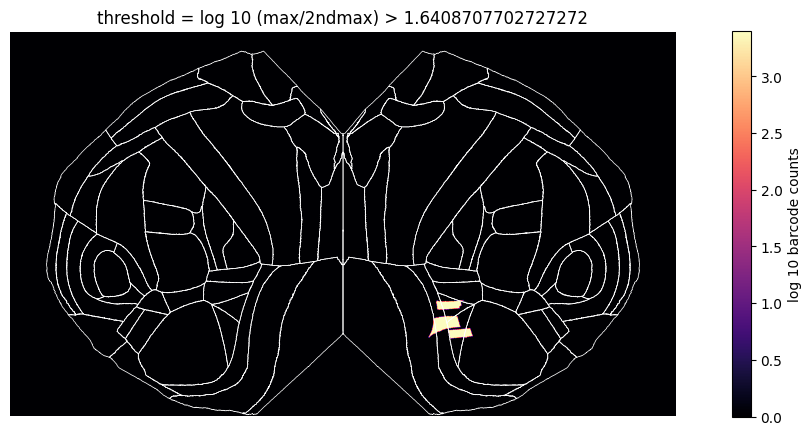

In [30]:
new_mat = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T

cmap = plt.cm.get_cmap("magma").copy()

cmap.set_bad(color=[0.3 , 0.3 , 0.3 , 1 ])  # Set NaN values as grey

plt.imshow(new_mat, cmap=cmap)
plt.axis('off')
plt.colorbar(label='log 10 barcode counts', fraction=0.03, pad=0.04)
for k, boundary_coords in bf_left_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.5)
plt.title(f'threshold = log 10 (max/2ndmax) > {threshold}')


In [38]:
areas = areas.set_index('sample')

In [46]:
source_areas = areas.copy()

In [48]:
source_areas['fraction_AUDp']= source_areas['AUDp']/source_areas.sum(axis=1)

In [50]:
source_areas = source_areas[source_areas['fraction_AUDp']>0.1]

In [51]:
source_areas 

,ACAd,ACAv,ACB,AId,AIp,AIv,APN,APr,AUDd,AUDp,...,Contra-SSs,Contra-TEa,Contra-VISC,Contra-or,Contra-scwm,Contra-alv,Contra-ar,Contra-ec,Contra-fp,fraction_AUDp
sample,,,,,,,,,,,,,,,,,,,,,
35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97943.386519,53001.166253,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.196310
36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35982.038219,153368.717625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149797
42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,330.029174,1075.650640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.711001
43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.584520,7621.582149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999137
51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,16256.119080,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.127150
53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,12930.812187,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.134043


In [54]:
#now look only at the barcodes with max barcode count in area containing at least 10% A1
source_thresholded = source_thresholded[source_thresholded.idxmax(axis=1).isin(source_areas.index)]

In [60]:
source_thresholded.to_pickle(normalised_barcode_path.parents[0]/'source_filtered_thresholded.pkl')

In [58]:
normalised_barcode_path.parents[0]

PosixPath('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/Sequencing/Source_target_together')